# PHYS 7730 (Data Science) Problem Set Summary
By Kaixin Wang and Prof. Michael Vershinin

## Question 5: Empirical Likelihood Method of quantile
Write code which estimates the $\alpha$ quantile of the data and its C.I. using empirical likelihood method. 

For example, if $\alpha=0.50$ then this would estimate a median (0.50 of the data above the estimate and 0.50 of the data below the estimate). 
You can assume that the data has no ties.

Example: Weibull Distribution

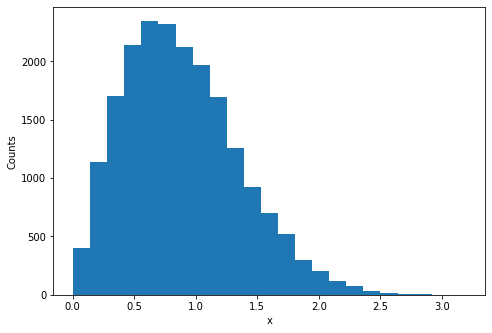

The ground truth mean is : 0.8862269254527579
The mean of the data is : 0.8871387172956947


In [16]:
import numpy as np
import scipy.optimize as SciOpt
import scipy.stats as SciStat
import scipy.special as SciSpec
from numpy import random as rnd
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.stats.distributions import chi2

Nsamples=int(2e4)
Shape=2
rvvec=rnd.weibull(Shape,(Nsamples,1));
#Plot the results
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.hist(rvvec,23)
plt.xlabel('x')
plt.ylabel('Counts')
plt.show()
print('The ground truth mean is : ' + str(SciSpec.gamma(1+1/Shape)))
print('The mean of the data is : ' + str(np.mean(rvvec)))

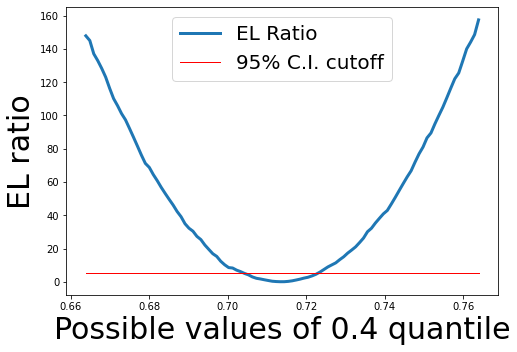

In [17]:
def ELR(data,Val,qVal): 
    #data is (...wait for it...) the vector of data
    #Val is the tentative value for quantity being estimated
    #Lam is the Lagrange multiplier
    #-------------------------------------------------------
    #Define the estimating function
    #The estimating function is an expression which
    #when averaged over the data and set to zero gives the desired
    #condition
    #Here we basically define a function which is 1 for data values
    #below Val and zero above that. When averaged over the entire data
    #set this gives us the actual quantile of Val which we can then
    #force to be qVal and see the resulting ELR from this constraint
    g=(data<Val)-qVal  # in boolean array, 'True' = 1 and 'False' = 0
    #Set up the Lagrange mutiplier condition for Lam
    constraintEQN = lambda L : sum(np.divide(g,1 + g*L)); 
    #Find the multiplier
    Lam=SciOpt.fsolve(constraintEQN,0)
    #return the Empirical Likelihood Ratio
    return 2*np.sum(np.log(1+Lam*g))
#
#Let's pick some value for quantile we want
alpha=0.4
#Let's pick some reasonable range for possible values of the quantile
x=np.linspace(np.quantile(rvvec,alpha)-0.05, np.quantile(rvvec,alpha)+0.05,100)
#I will also set up some indexing variable 
t=np.linspace(0,len(x)-1,len(x)).astype(int)
#We will record ELR values in y, so let's start with initializing
#this variable to be all zeros and same size as x
y=0*x
#For every possible mean value in our range compute ELR
for ii in t:
    y[ii]=ELR(rvvec,x[ii],alpha) 
#Plot the output to the user
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#The ELR curve
plt.plot(x,y,label='EL Ratio', linewidth=3)
#The cutoff line for 95% confidence
plt.plot(x,x*0+chi2.ppf(0.975, df=1),'r',label='95% C.I. cutoff', linewidth=1)
plt.legend(fontsize=20)
plt.xlabel('Possible values of ' + str(alpha) + ' quantile', fontsize=30)
plt.ylabel('EL ratio', fontsize=30)
plt.show()
#While we are at it, let's record the location of minimum ELR
cen=x[np.argmin(y)] ### np.argmin() returns the index of min

In [18]:
#Define cost function which sets target ELR based on confidence level
ELRiterator = lambda p : ELR(rvvec,p,alpha)-chi2.ppf(0.975, df=1); 
#Use brent method to find intersection point for ELR and cutoff...
#... on the right side of minimum
limHi=SciOpt.brentq(ELRiterator, cen, cen+0.04)  ### Find a root of a function in a bracketing interval using Brent’s method
#... on the left side of minimum
limLo=SciOpt.brentq(ELRiterator, cen-0.04, cen)
#Dump output to user
print('The target quantile of the data is       : ' + str(np.quantile(rvvec,alpha)))
print('The 95% CI for MELE :')
print((limLo, limHi))

The target quantile of the data is       : 0.7138424156195404
The 95% CI for MELE :
(0.704118970829028, 0.7226915732127506)


In [19]:
#bootstrap
#Format the data for python's bootstrap
data=(rvvec,)
#Do bootstrap
q = lambda data : np.quantile(data,alpha)
res = SciStat.bootstrap(data, q, vectorized=False, batch=1, confidence_level=0.95)
ci=res.confidence_interval; 
#Dump output to the user
print('-------------------------------------------')
print('The target quantile of the data is       : ' + str(q(data)))
print('The 95% CI for MELE :')
print((limLo, limHi))
print('Bootstrap C.I. : ');
print((ci.low[0], ci.high[0]))

-------------------------------------------
The target quantile of the data is       : 0.7138424156195404
The 95% CI for MELE :
(0.704118970829028, 0.7226915732127506)
Bootstrap C.I. : 
(0.7055113251313287, 0.7218238482101409)
